# Convolutional Neural Network

## Packages

In [1]:
# ----- Tensorflow -----
import tensorflow as tf
from keras.models import Model
from keras.layers import Flatten, Dense, Input
from keras import optimizers as opt

# ----- Transfer learning -----
from keras.applications import NASNetLarge
from keras.applications import EfficientNetB0
from keras.applications import MobileNetV2

# ----- plot -----
import matplotlib.pyplot as plt

# ----- Utility functions -----
from utils import load_data, plot_hist, plot_hist_sideways, _convert_sample

# ------ Data ------
import numpy as np


## Load Data

In [3]:
data_dir = "C:/Users/chris/OneDrive - Syddansk Universitet/kandidat/3_semester/Maskinlæring/ds807_anvendt_maskinlæring/eksamen/exam/patch_camelyon"
BATCH_SIZE = 32
train, test, val = load_data(data_dir, perc=1, batch_size=BATCH_SIZE)

## Transfer Learning
- Discuss and apply transfer learning. Motivate what type of transfer learning you use and how you apply it, including considerations for how to prepare the data for this. Here, be sure to visualize plots of train and validation losses and accuracies.



## Feature Extraction Approach
For the feature extraction approach, we will utilize a large network, since we do not have to train it, we can utilize its size and save computational ressources. In this case we are using NasNetLarge, since it is one of the best performing models in terms of accuracy for image classification. However, it is a HUGE model, and will take time to even load.
However, we will also try with mobilenet v2 since it has been trained on 96 x 96 pixel images

### Helper Functions

In [32]:
def get_x(dataset):
    """
    Returns all y from tensorflow data set
    """
    return tf.convert_to_tensor([x for _, x in dataset.unbatch()])

def get_y(dataset):
    """
    Returns all x from a tensorflow data set
    """
    return tf.convert_to_tensor([y for _, y in dataset.unbatch()])

def get_x_y(dataset):
    """
    Returns all x and y from a tensorflow data set
    """
    return get_x(dataset), get_y(dataset) 


# Y labels 
y_train = get_y(train)
y_val = get_y(val)

### Build Feature Extractor with NasNet Large

#### Feature Extractor

In [5]:
# Initilize NasNetLarge Feature Extractor
NasNet_ft_extractor = NASNetLarge(
    input_shape=(96, 96, 3),
    include_top= False,
    weights='imagenet'
)
NasNet_ft_extractor.trainable = False

343610240/343610240 [==============================] - 30s 0us/step


#### Classifier

In [37]:
# Build classifer
x = NasNet_ft_extractor.output
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='softmax')(x)
m_nasnet = Model(inputs = NasNet_ft_extractor.output, outputs = output)

# Compile model
m_nasnet.compile(
    optimizer = opt.Nadam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    )

#### Extract Features

In [38]:
# X features
nasnet_fts_train = NasNet_ft_extractor.predict(train)
nasnet_fts_val = NasNet_ft_extractor.predict(val)

11/11 [==============================] - 22s 2s/step


#### Train model with Nasnet Features

In [39]:
history_nasnet = m_nasnet.fit(x = nasnet_fts_train, y = y_train, validation_data = (nasnet_fts_val, y_val), epochs = 5, batch_size = 32)


Epoch 1/5
82/82 [==============================] - 7s 72ms/step - loss: 0.6434 - accuracy: 0.6726 - val_loss: 0.5177 - val_accuracy: 0.7165
Epoch 2/5
82/82 [==============================] - 6s 71ms/step - loss: 0.3707 - accuracy: 0.8451 - val_loss: 0.5424 - val_accuracy: 0.7104
Epoch 3/5
82/82 [==============================] - 6s 71ms/step - loss: 0.2137 - accuracy: 0.9294 - val_loss: 0.5555 - val_accuracy: 0.7500
Epoch 4/5
82/82 [==============================] - 6s 73ms/step - loss: 0.1157 - accuracy: 0.9699 - val_loss: 0.7454 - val_accuracy: 0.7134
Epoch 5/5
82/82 [==============================] - 6s 71ms/step - loss: 0.0553 - accuracy: 0.9916 - val_loss: 0.7576 - val_accuracy: 0.7439


### Feature extractor with MobileNetV2

#### Feature Extractor

In [42]:
# Layers for feature extraction
mobilev2_ft_extractor = MobileNetV2(
    input_shape=(96, 96, 3),
    include_top= False,
    weights='imagenet'
)
mobilev2_ft_extractor.trainable = False

#### Classifier

In [43]:
# Full model
x = mobilev2_ft_extractor.output
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='softmax')(x)
m_mobilev2 = Model(inputs = mobilev2_ft_extractor.output, outputs = output)

# Compile model
m_mobilev2.compile(
    optimizer = opt.Nadam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    )

#### Extract Features

In [44]:
# Extract Features
mobilev2_fts_train = mobilev2_ft_extractor.predict(train)
mobilev2_fts_val = mobilev2_ft_extractor.predict(val)

11/11 [==============================] - 2s 201ms/step


#### Train model with mobilev2 features

In [45]:
history_mobile_v2 = m_mobilev2.fit(x = mobilev2_fts_train, y = y_train, validation_data = (mobilev2_fts_val, y_val), epochs = 5)

Epoch 1/5
82/82 [==============================] - 3s 20ms/step - loss: 0.6154 - accuracy: 0.7665 - val_loss: 0.3485 - val_accuracy: 0.8537
Epoch 2/5
82/82 [==============================] - 1s 17ms/step - loss: 0.3425 - accuracy: 0.8401 - val_loss: 0.3291 - val_accuracy: 0.8689
Epoch 3/5
82/82 [==============================] - 1s 18ms/step - loss: 0.2466 - accuracy: 0.8939 - val_loss: 0.3635 - val_accuracy: 0.8262
Epoch 4/5
82/82 [==============================] - 1s 17ms/step - loss: 0.1857 - accuracy: 0.9203 - val_loss: 0.3869 - val_accuracy: 0.8293
Epoch 5/5
82/82 [==============================] - 1s 18ms/step - loss: 0.1431 - accuracy: 0.9424 - val_loss: 0.3856 - val_accuracy: 0.8598


### Feature extractor with EfficientNet B0

#### Feature extractor

In [46]:
# Layers for feature extraction
efficient_ft_extractor = EfficientNetB0(
    input_shape=(96, 96, 3),
    include_top= False,
    weights='imagenet'
)
efficient_ft_extractor.trainable = False

16705208/16705208 [==============================] - 2s 0us/step


#### Classifier

In [47]:
# Full model
x = efficient_ft_extractor.output
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='softmax')(x)
m_efficient = Model(inputs = efficient_ft_extractor.output, outputs = output)

# Compile model
m_efficient.compile(
    optimizer = opt.Nadam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    )

#### Extract Features

In [48]:
# X features
efficient_fts_train = efficient_ft_extractor.predict(train)
efficient_fts_val = efficient_ft_extractor.predict(val)

11/11 [==============================] - 4s 339ms/step


#### Train model with EffcientNet B0 features

In [49]:
history_efficient = m_efficient.fit(x = efficient_fts_train, y = y_train, validation_data = (efficient_fts_val, y_val), epochs = 5)

Epoch 1/5
82/82 [==============================] - 3s 21ms/step - loss: 0.8171 - accuracy: 0.5185 - val_loss: 0.6928 - val_accuracy: 0.5549
Epoch 2/5
82/82 [==============================] - 1s 17ms/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6928 - val_accuracy: 0.5549
Epoch 3/5
82/82 [==============================] - 1s 17ms/step - loss: 0.6932 - accuracy: 0.4926 - val_loss: 0.6928 - val_accuracy: 0.5549
Epoch 4/5
82/82 [==============================] - 1s 17ms/step - loss: 0.6932 - accuracy: 0.4910 - val_loss: 0.6927 - val_accuracy: 0.5549
Epoch 5/5
82/82 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6928 - val_accuracy: 0.5549


### Plot Results

#### NasNet

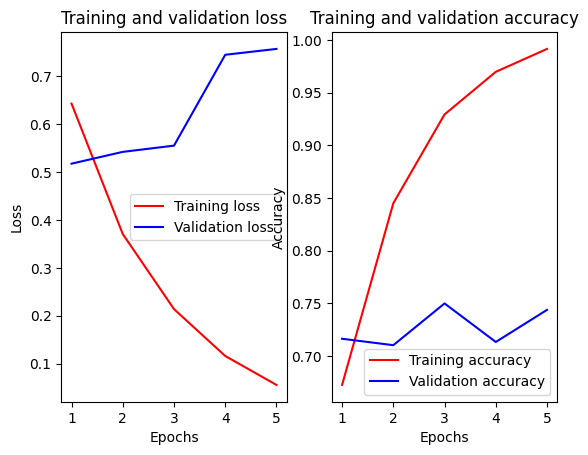

In [50]:
plot_hist_sideways(history_nasnet)

#### MobileNet V2

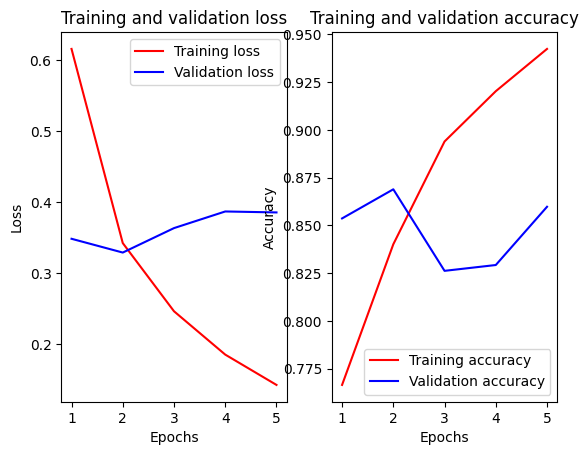

In [51]:
plot_hist_sideways(history_mobile_v2)

#### EfficientNet B0

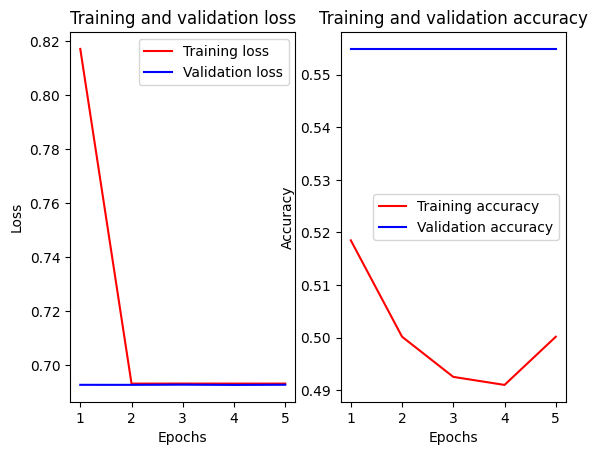

In [52]:
plot_hist_sideways(history_efficient)

## Fine Tuning Approach
- For our fine tuning approach we will use a smaller and more efficient model, since we will be retraining it. We are therefore, using EfficientNet B0